In [23]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import requests
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

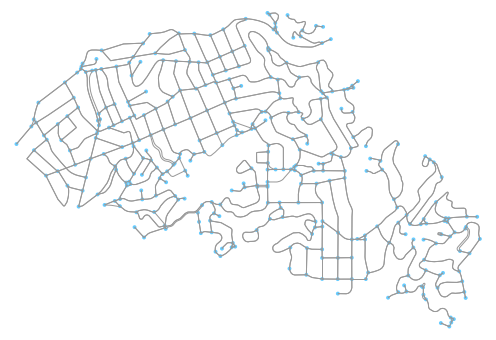

In [5]:
# get a graph for some city
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
fig, ax = ox.plot_graph(G)

In [6]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4224782.349449131

In [7]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 346,
 'm': 938,
 'k_avg': 5.421965317919075,
 'intersection_count': 312,
 'streets_per_node_avg': 2.953757225433526,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 263, 4: 47, 5: 1, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.09826589595375723,
  2: 0.0,
  3: 0.7601156069364162,
  4: 0.13583815028901733,
  5: 0.002890173410404624,
  6: 0.002890173410404624},
 'edge_length_total': 113866.17199999992,
 'edge_length_avg': 121.39250746268648,
 'street_length_total': 59407.70500000004,
 'street_length_avg': 121.24021428571436,
 'street_segments_count': 490,
 'node_density_km': 81.89771007851208,
 'intersection_density_km': 73.84995822108604,
 'edge_density_km': 26951.961682676254,
 'street_density_km': 14061.719654681432,
 'circuity_avg': 1.1135507575816157,
 'self_loop_proportion': 0.006396588486140725,
 'clean_intersection_count': 271,
 'clean_intersection_density_km': 64.1453162753664}

In [8]:

# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


In [9]:
# pull up some stat's value
more_stats['radius']

2507.4629999999997

In [10]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

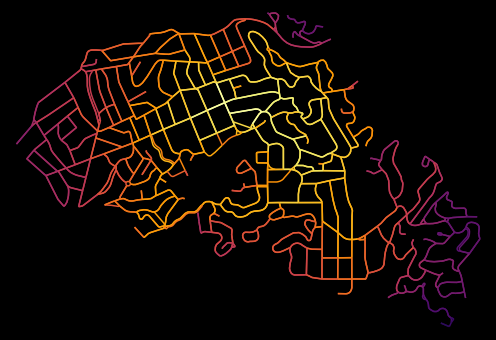

In [11]:
# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

In [18]:
#Inspect betweenness centrality
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc




(53124805, 0.3160542060808595)

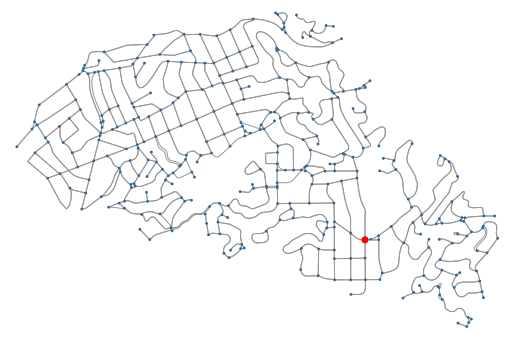

In [21]:
nc = ['r' if node==max_node else '#336699' for node in G_projected.nodes()]
ns = [50 if node==max_node else 8 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2)



29.4% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

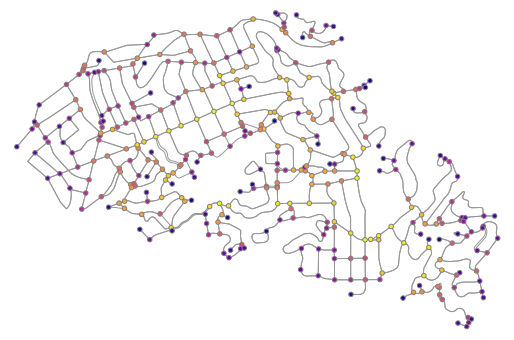

In [24]:
# get a color for each node
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G_projected, node_color=nc, node_edgecolor='gray', node_size=20, node_zorder=2)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow).